In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

#Standardization
tf.set_random_seed(777)
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()


# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) 

# Reverse
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

# Loading Data
Weekly_file_name = 'ic8.csv' 
encoding = 'euc-kr' 
names = ['Holiday','Japan','China','Northeast Asia','Southeast Asia','Americas','Europe','Oceania','Middle East','Others','Total']
raw_dataframe = pd.read_csv(Weekly_file_name, names=names, encoding=encoding) 
raw_dataframe.info()
Weekly_info = raw_dataframe.values[1:].astype(np.float) 


# Hyper parameter
input_data_column_cnt = 11  
output_data_column_cnt = 1 

seq_length = 12        
rnn_cell_hidden_dim = 200   
forget_bias = 1.0         
num_stacked_layers = 1    
keep_prob = 0.9            

epoch_num =240        
learning_rate = 0.01


C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 11 columns):
Holiday           261 non-null object
Japan             261 non-null object
China             261 non-null object
Northeast Asia    261 non-null object
Southeast Asia    261 non-null object
Americas          261 non-null object
Europe            261 non-null object
Oceania           261 non-null object
Middle East       261 non-null object
Others            261 non-null object
Total             261 non-null object
dtypes: object(11)
memory usage: 22.5+ KB


In [2]:
# Data preprocessing
holiday = Weekly_info[:,:1]
norm_holiday = min_max_scaling(holiday)
print("holiday.shape: ", holiday.shape)
print("holiday[0]: ", holiday[0])
print("norm_holiday[0]: ", norm_holiday[0])
print("="*100) 

continent = Weekly_info[:,1:-1]
norm_continent = min_max_scaling(continent) 
print("continent.shape: ", continent.shape)
print("continent[0]: ", continent[0])
print("norm_continent[0]: ", norm_continent[0])
print("="*100) 

total = Weekly_info[:,-1:]
norm_total = min_max_scaling(total) 
print("total.shape: ", total.shape)
print("total[0]: ", total[0])
print("norm_total[0]: ", norm_total[0])
print("="*100) 

x = np.concatenate((norm_continent, norm_holiday,  norm_total), axis=1) 
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    
print("x[-1]: ", x[-1])  
print("="*100) 

y = x[:, [-1]] 
print("y[0]: ",y[0])    
print("y[-1]: ",y[-1])   

holiday.shape:  (260, 1)
holiday[0]:  [2.]
norm_holiday[0]:  [0.]
continent.shape:  (260, 9)
continent[0]:  [114598. 155914.  92300. 251002.  89373.  49811.  66771.  15866.   6781.]
norm_continent[0]:  [0.25505599 0.35009385 0.20376462 0.56882171 0.19703173 0.10602854
 0.14504108 0.02794595 0.00704802]
total.shape:  (260, 1)
total[0]:  [842416.]
norm_total[0]:  [0.1760101]
x.shape:  (260, 11)
x[0]:  [0.25505599 0.35009385 0.20376462 0.56882171 0.19703173 0.10602854
 0.14504108 0.02794595 0.00704802 0.         0.1760101 ]
x[-1]:  [0.65680925 0.51465501 0.34217633 0.97416799 0.22102583 0.1280145
 0.21087935 0.02254492 0.01142543 0.2        0.92694142]
y[0]:  [0.1760101]
y[-1]:  [0.92694142]


In [3]:
dataX = [] 
dataY = [] 

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] 
    if i is 0:
        print(_x, "->", _y) 
    dataX.append(_x)
    dataY.append(_y) 

train_size = int(len(dataY) * 0.6)
test_size = len(dataY) - train_size

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])    

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
Y = tf.placeholder(tf.float32, [None, 1])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])

def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

loss =tf.reduce_sum(tf.square(hypothesis - Y))
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))
mape = tf.reduce_mean(tf.abs((predictions-targets))/targets)*100
mse=tf.reduce_mean(tf.square(predictions - targets))

[[0.25505599 0.35009385 0.20376462 0.56882171 0.19703173 0.10602854
  0.14504108 0.02794595 0.00704802 0.         0.1760101 ]
 [0.27597462 0.38765722 0.21493932 0.58831648 0.18673574 0.1108545
  0.1409121  0.030957   0.00764149 0.         0.22715832]
 [0.28443041 0.41540305 0.21838742 0.55168242 0.17617291 0.10961696
  0.14443611 0.03526771 0.00786001 0.         0.2267084 ]
 [0.26646992 0.3788334  0.22865582 0.50324798 0.14969452 0.10516134
  0.12143343 0.029172   0.00638094 0.39999999 0.13185831]
 [0.26697598 0.42187141 0.241443   0.52621155 0.15370619 0.10491061
  0.12354738 0.02915359 0.00653966 0.         0.18433083]
 [0.30048168 0.40102868 0.21510034 0.55386767 0.16192735 0.1031118
  0.13424133 0.03133195 0.00651436 0.         0.20477964]
 [0.32118639 0.42122043 0.22370334 0.57222841 0.16183994 0.10665421
  0.13815868 0.03374723 0.00742756 0.         0.253101  ]
 [0.31204742 0.41555027 0.21570991 0.52224589 0.15950747 0.10164653
  0.140896   0.03173219 0.00715153 0.         0.2040

In [4]:
train_error_summary = [] 
test_error_summary = []  
test_error_summary2 = []
test_predict = ''        

sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = datetime.datetime.now() 
print('Start Learning!')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 10 == 0) or (epoch == epoch_num-1): 
        
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error) 
        train_error2 = sess.run(mape, feed_dict={targets: trainY, predictions: train_predict})
        train_error3 = sess.run(mse, feed_dict={targets: trainY, predictions: train_predict})
        
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        test_error2 = sess.run(mape, feed_dict={targets: testY, predictions: test_predict})
        test_error3 = sess.run(mse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary2.append(test_error2)
        
        print("epoch: {}, RMSE(train): {}, RMSE(test): {}".format(epoch+1, train_error, test_error))
        print("epoch: {}, MAPE(train): {}, MAPE(test): {}".format(epoch+1, train_error2, test_error2))
        print("epoch: {}, MSE(train): {}, MSE(test): {}".format(epoch+1, train_error3, test_error3))
end_time = datetime.datetime.now() 
elapsed_time = end_time - start_time 
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

Start Learning!
epoch: 10, RMSE(train): 0.16248111426830292, RMSE(test): 0.2569149434566498
epoch: 10, MAPE(train): inf, MAPE(test): 28.805530548095703
epoch: 10, MSE(train): 0.026400111615657806, MSE(test): 0.06600528210401535
epoch: 20, RMSE(train): 0.15816274285316467, RMSE(test): 0.2321244329214096
epoch: 20, MAPE(train): inf, MAPE(test): 25.547569274902344
epoch: 20, MSE(train): 0.02501545287668705, MSE(test): 0.053881753236055374
epoch: 30, RMSE(train): 0.13825646042823792, RMSE(test): 0.30047425627708435
epoch: 30, MAPE(train): inf, MAPE(test): 35.93659210205078
epoch: 30, MSE(train): 0.019114848226308823, MSE(test): 0.09028477966785431
epoch: 40, RMSE(train): 0.11319965124130249, RMSE(test): 0.21523180603981018
epoch: 40, MAPE(train): inf, MAPE(test): 24.544395446777344
epoch: 40, MSE(train): 0.01281416043639183, MSE(test): 0.046324729919433594
epoch: 50, RMSE(train): 0.09349408745765686, RMSE(test): 0.11586505174636841
epoch: 50, MAPE(train): inf, MAPE(test): 12.64906501770019

input_data_column_cnt: 11,output_data_column_cnt: 1,seq_length: 12,rnn_cell_hidden_dim: 200,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 0.9,epoch_num: 240,learning_rate: 0.01,train_error: 0.051249642,test_error: 0.06993915,min_train_error: 0.050954554
,min_test_error: 0.06993915


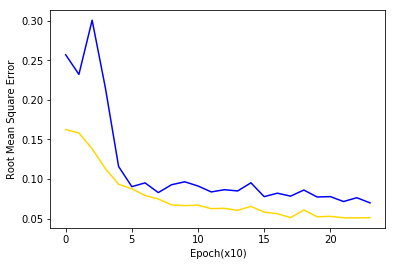

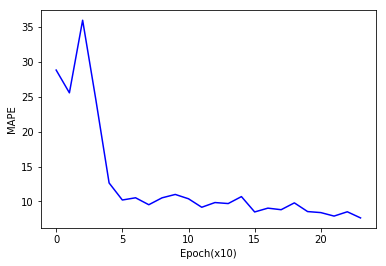

<Figure size 432x288 with 0 Axes>

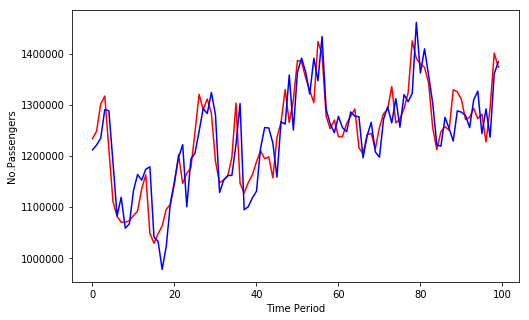

In [5]:
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_train_error:', np.min(train_error_summary))
print(',min_test_error:', np.min(test_error_summary))

plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x10)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(test_error_summary2, 'b')
plt.xlabel('Epoch(x10)')
plt.ylabel('MAPE')

plt.figure(3)
plt.figure(figsize=(8,5))
test_Y = reverse_min_max_scaling(total,testY)
test_predict1 = reverse_min_max_scaling(total,test_predict)
plt.plot(test_Y, 'r')
plt.plot(test_predict1, 'b')
plt.xlabel('Time Period')
plt.ylabel('No.Passengers')
plt.show()

In [6]:
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(total,test_predict) 
print("Next week number of passengers are", int(test_predict[0])) 

recent_data.shape: (1, 12, 11)
recent_data: [[[0.56580146 0.58008612 0.32806189 0.80226898 0.23569463 0.12673785
   0.29002466 0.03924947 0.01258707 0.2        0.86470361]
  [0.58183893 0.59041202 0.33153299 0.79076074 0.23443639 0.11458554
   0.28051075 0.03495027 0.01182108 0.         0.85875983]
  [0.5876264  0.57619867 0.33447963 0.81133894 0.21897169 0.09768087
   0.26181878 0.03421878 0.01408684 0.         0.83758378]
  [0.547213   0.53223135 0.33340771 0.84459621 0.20907364 0.09984542
   0.23417416 0.03074768 0.01500465 0.         0.78214856]
  [0.56536441 0.53457532 0.3393171  0.840228   0.20980972 0.09584066
   0.23037182 0.03001159 0.01110569 0.         0.78850265]
  [0.58727906 0.51986741 0.34514597 0.85954335 0.21685544 0.09974421
   0.22130186 0.03193232 0.01445718 0.         0.81279986]
  [0.59718171 0.51240534 0.32513595 0.87779828 0.19777012 0.10101166
   0.19821867 0.02617705 0.01396032 0.         0.78421849]
  [0.59887011 0.50670068 0.3143914  0.90683686 0.20582566 0.